# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("X_train.txt")
y_train = np.loadtxt("y_train.txt").astype(int)

X_test = np.loadtxt("X_test.txt")
y_test = np.loadtxt("y_test.txt").astype(int)

In [5]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [6]:
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

Определим число уникальных значений меток целевого класса.

In [7]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [8]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [11]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [12]:
print(pca.n_components_)

65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [13]:
print(round(pca.explained_variance_ratio_[0] * 100))

51


Визуализируйте данные в проекции на первые две главные компоненты.

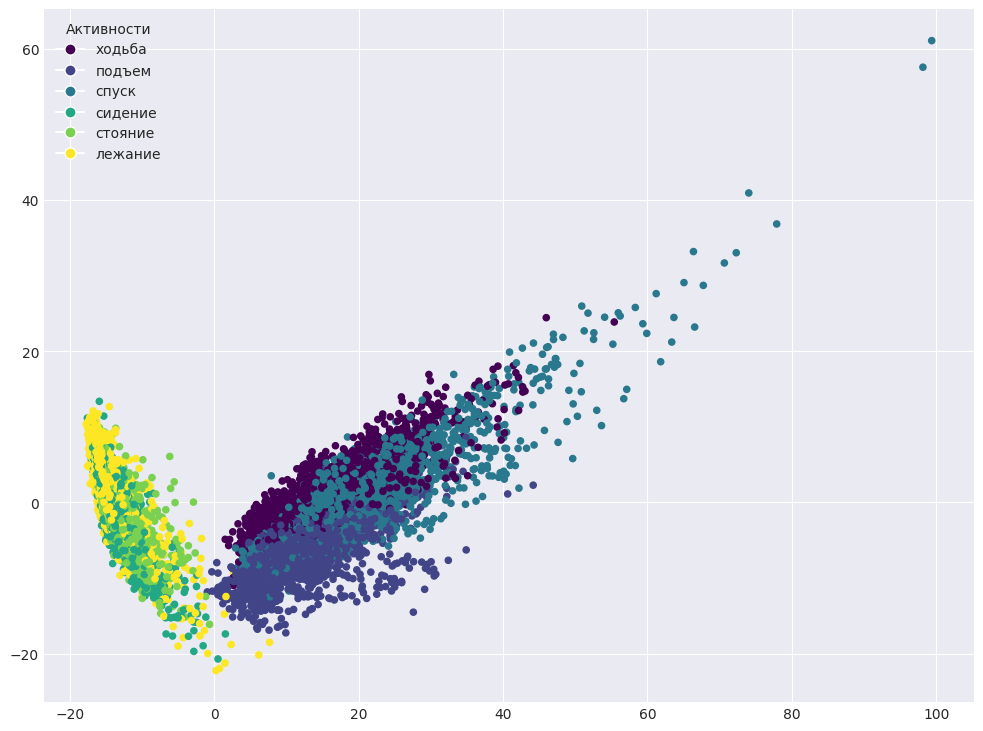

In [14]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
activities = {1: 'ходьба', 2: 'подъем', 3: 'спуск', 4: 'сидение', 5: 'стояние', 6: 'лежание'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / 5), markersize=8) for i in range(6)]
plt.legend(handles, [activities[i + 1] for i in range(6)], title='Активности')

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans_labels = kmeans.fit_predict(X_pca)

In [16]:
def _closest_centroid(X, centroids):
    distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
    return np.argmin(distances, axis=1)


class CustomKMeans:
    def __init__(self, n_clusters, n_init, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.random_state = random_state

        self.cluster_centers_ = None
        self.inertia_ = None
        self.labels_ = None

    def _init_centroids(self, X):
        rng = np.random.default_rng(self.random_state)
        indices = rng.choice(len(X), self.n_clusters, replace=False)
        return X[indices]

    def _compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) == 0:
                centroids[k] = X[np.random.randint(0, len(X))]
            else:
                centroids[k] = cluster_points.mean(axis=0)
        return centroids

    def _compute_inertia(self, X, centroids, labels):
        _inertia = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            _inertia += ((cluster_points - centroids[k]) ** 2).sum()
        return _inertia

    def fit(self, X):
        X = np.asarray(X)

        best_inertia = None
        best_centroids = None
        best_labels = None

        for _ in range(self.n_init):
            centroids = self._init_centroids(X)
            
            labels = _closest_centroid(X, centroids)

            for _ in range(300):
                old_centroids = centroids.copy()

                labels = _closest_centroid(X, centroids)

                centroids = self._compute_centroids(X, labels)

                shift = np.linalg.norm(centroids - old_centroids)
                if shift < 1e-4:
                    break

            _inertia = self._compute_inertia(X, centroids, labels)

            if best_inertia is None or _inertia < best_inertia:
                best_inertia = _inertia
                best_centroids = centroids
                best_labels = labels

        self.cluster_centers_ = best_centroids
        self.inertia_ = best_inertia
        self.labels_ = best_labels
        return self

    def predict(self, X):
        X = np.asarray(X)
        return _closest_centroid(X, self.cluster_centers_)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_


custom_kmeans = CustomKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
custom_kmeans_labels = custom_kmeans.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

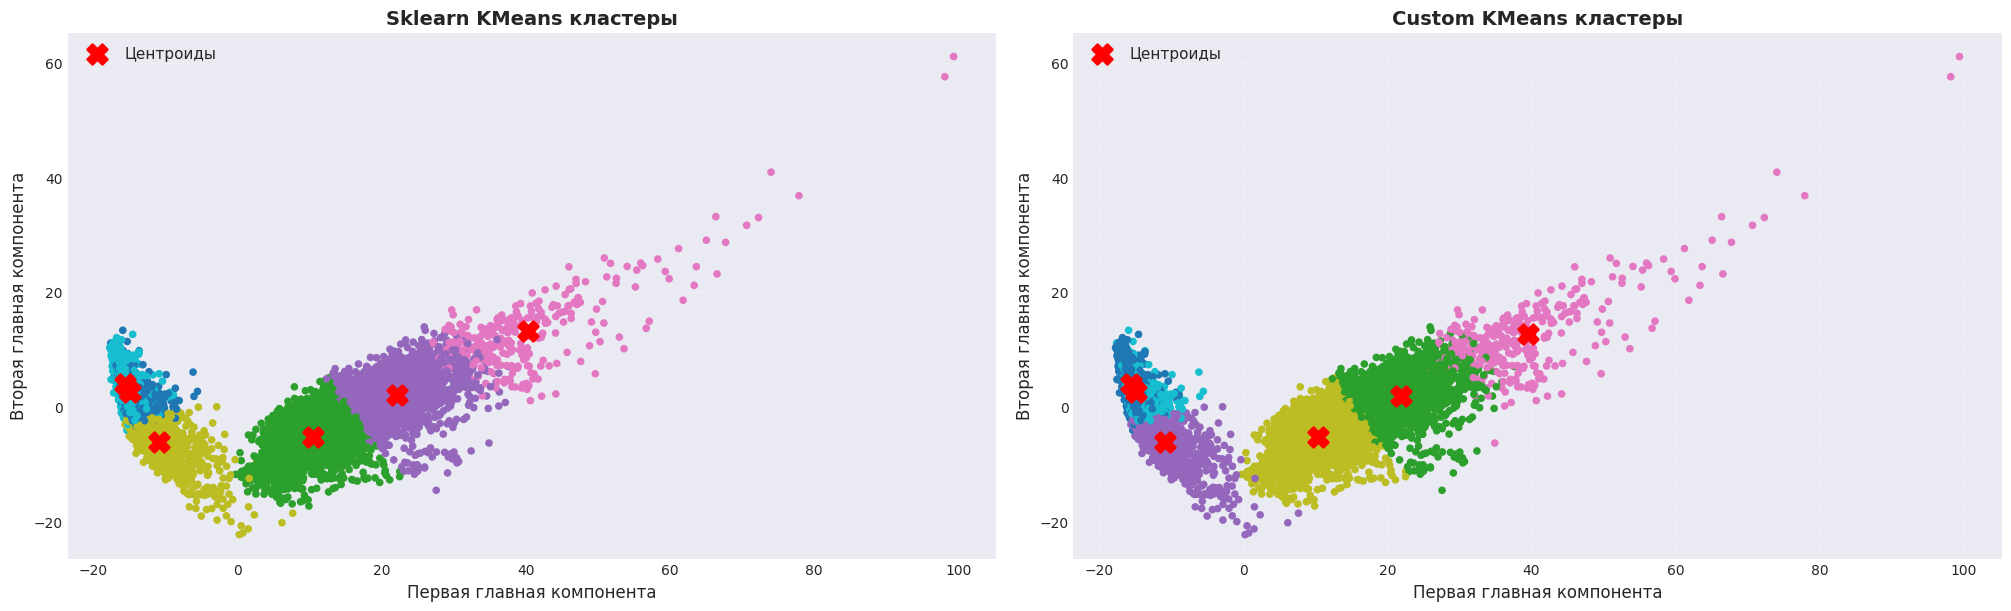

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)

cmap = plt.colormaps['tab10'].resampled(n_classes)

scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                      cmap=cmap, s=20, vmin=0, vmax=n_classes-1)
ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='X', s=200, color='red', linewidths=2, label='Центроиды',
            zorder=10)  # zorder чтобы центроиды были поверх точек
ax1.set_xlabel('Первая главная компонента', fontsize=12)
ax1.set_ylabel('Вторая главная компонента', fontsize=12)
ax1.set_title('Sklearn KMeans кластеры', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=custom_kmeans_labels,
                      cmap=cmap, s=20, vmin=0, vmax=n_classes-1)
ax2.scatter(custom_kmeans.cluster_centers_[:, 0], custom_kmeans.cluster_centers_[:, 1],
            marker='X', s=200, color='red', linewidths=2, label='Центроиды',
            zorder=10)
ax2.set_xlabel('Первая главная компонента', fontsize=12)
ax2.set_ylabel('Вторая главная компонента', fontsize=12)
ax2.set_title('Custom KMeans кластеры', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [25]:
tab = pd.crosstab(y, custom_kmeans_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,740,0,85,897,0,1722
подъем вверх по лестнице,0,295,2,9,1238,0,1544
спуск по лестнице,0,883,0,214,309,0,1406
сидение,90,0,451,0,1,1235,1777
стояние,0,0,566,0,0,1340,1906
лежание,1556,0,330,0,5,53,1944
все,1646,1918,1349,308,2450,2628,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

C:\Users\Михаил\AppData\Local\Temp\ipykernel_10296\4087308907.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

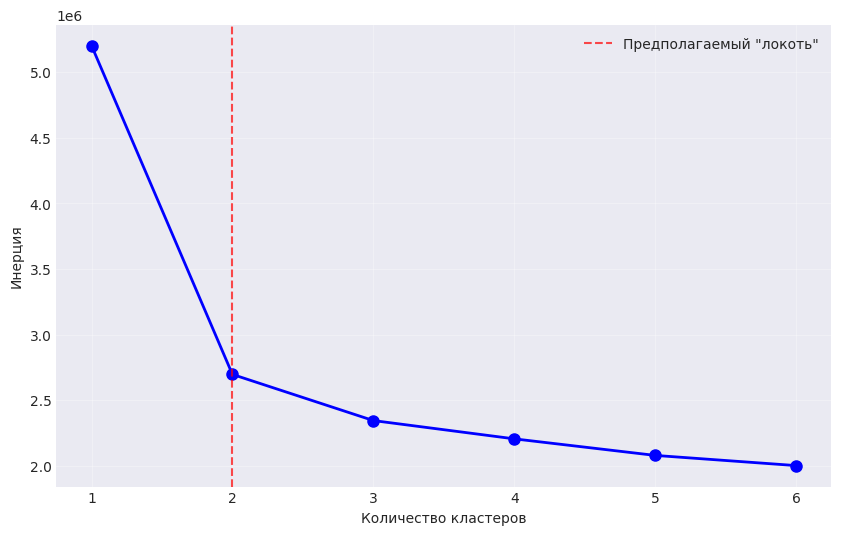

In [26]:
inertia = []

for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_classes + 1), inertia, 'bo-', markersize=8, linewidth=2)
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, n_classes + 1))

plt.axvline(x=2, color='red', linestyle='--', alpha=0.7, label='Предполагаемый "локоть"')
plt.legend()

plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [27]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [28]:
from sklearn.metrics import adjusted_rand_score

ag_labels = ag.labels_

ari_ag = adjusted_rand_score(y, ag_labels)

ari_kmeans = adjusted_rand_score(y, kmeans_labels)

ari_ag_vs_kmeans = adjusted_rand_score(ag_labels, kmeans_labels)

print(f"AG vs Y: {ari_ag:.4f}")
print(f"KMeans vs Y: {ari_kmeans:.4f}")
print(f"AG vs KMeans: {ari_ag_vs_kmeans:.4f}")

AG vs Y: 0.4936
KMeans vs Y: 0.4198
AG vs KMeans: 0.6915


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [29]:
scaler_classif = StandardScaler()
X_train_scaled = scaler_classif.fit_transform(X_train)
X_test_scaled = scaler_classif.transform(X_test)

In [30]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [31]:
best_svc = GridSearchCV(svc, svc_params, cv=3, scoring='accuracy', n_jobs=-1)
best_svc.fit(X_train_scaled, y_train)

,estimator,LinearSVC(random_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [32]:
best_svc.best_params_

{'C': 0.1}

**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [15]:
y_predicted = best_svc.predict(X_test_scaled)

In [17]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [33]:
pca_classif = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_classif.fit_transform(X_train_scaled)
X_test_pca = pca_classif.transform(X_test_scaled)

svc_pca = LinearSVC(random_state=RANDOM_STATE)
best_svc_pca = GridSearchCV(svc_pca, {'C': [0.001, 0.01, 0.1, 1, 10]}, cv=3)
best_svc_pca.fit(X_train_pca, y_train)

best_accuracy_original = best_svc.best_score_
best_accuracy_pca = best_svc_pca.best_score_

difference = abs(best_accuracy_original - best_accuracy_pca)
difference_percent = difference * 100
difference_rounded = round(difference_percent)

print(f"Лучшая точность на всех 561 признаках: {best_accuracy_original:.4f} ({best_accuracy_original*100:.1f}%)")
print(f"Лучшая точность на PCA-признаках: {best_accuracy_pca:.4f} ({best_accuracy_pca*100:.1f}%)")
print(f"Абсолютная разница: {difference:.4f}")
print(f"Разница в процентах: {round(difference_percent)}%")

Лучшая точность на всех 561 признаках: 0.9380 (93.8%)
Лучшая точность на PCA-признаках: 0.8984 (89.8%)
Абсолютная разница: 0.0396
Разница в процентах: 4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

eps: 4.26
min_samples: 35
k для анализа: 35


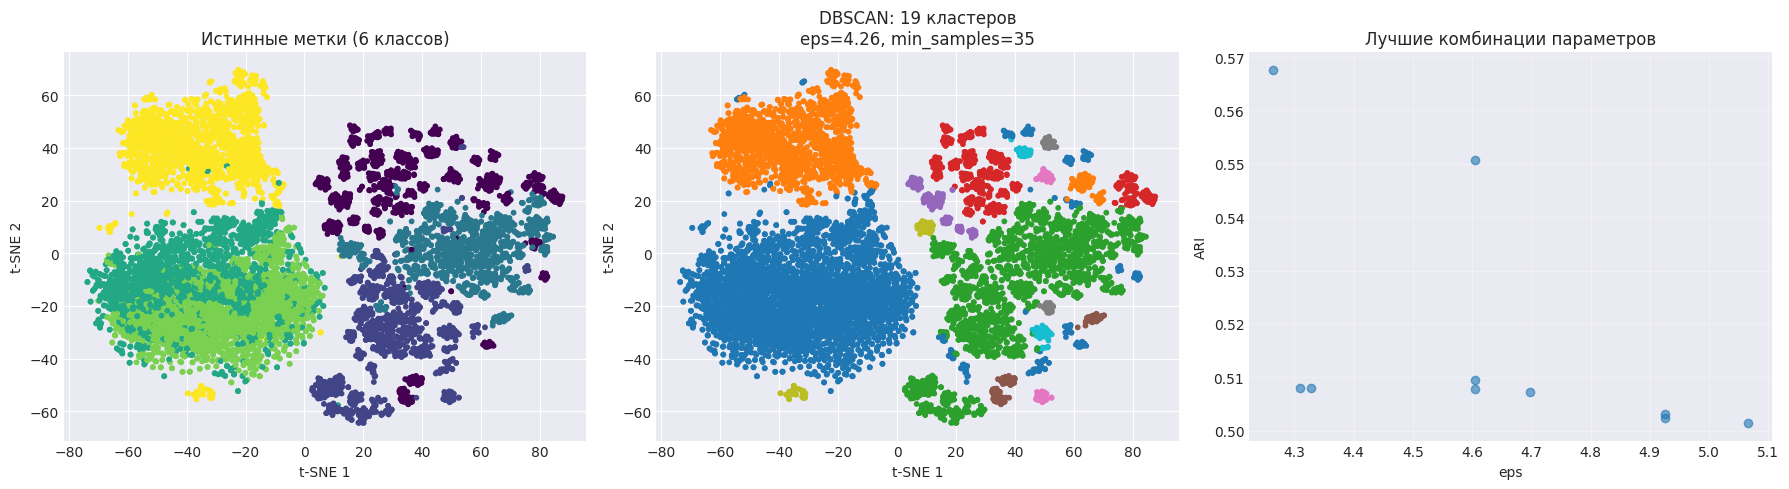

Кластеров: 19
Точек шума: 426 (4.1%)
ARI: 0.568


In [34]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

X_tsne = TSNE(n_components=2, random_state=17, perplexity=50).fit_transform(X_scaled)


def find_optimal_dbscan_params(X, k_range=range(5, 50, 5)):
    _best_params = None
    _best_ari = -1
    results = []

    for k in k_range:
        nn = NearestNeighbors(n_neighbors=k)
        nn.fit(X)
        distances, _ = nn.kneighbors(X)
        k_distances = np.sort(distances[:, -1])

        percentiles = [85, 90, 95]
        eps_candidates = [np.percentile(k_distances, p) for p in percentiles]

        for eps in eps_candidates:
            for min_samples in [k, k + 5, k + 10]:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(X)

                n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)

                if 2 <= n_clusters <= 20:
                    try:
                        ari = adjusted_rand_score(y, labels)
                        if ari > _best_ari:
                            _best_ari = ari
                            _best_params = {'eps': eps, 'min_samples': min_samples, 'k': k}
                        results.append((eps, min_samples, n_clusters, ari))
                    except:
                        continue

    return _best_params, _best_ari, results


best_params, best_ari, all_results = find_optimal_dbscan_params(X_tsne)

print(f"eps: {best_params['eps']:.2f}")
print(f"min_samples: {best_params['min_samples']}")
print(f"k для анализа: {best_params['k']}")

dbscan_optimal = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan_labels_optimal = dbscan_optimal.fit_predict(X_tsne)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=10, cmap='viridis')
axes[0].set_title('Истинные метки (6 классов)')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')

scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels_optimal, s=10, cmap='tab10')
axes[1].set_title(
    f'DBSCAN: {len(np.unique(dbscan_labels_optimal)) - 1} кластеров\neps={best_params["eps"]:.2f}, min_samples={best_params["min_samples"]}')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

if len(all_results) > 0:
    results_df = sorted(all_results, key=lambda x: x[3], reverse=True)[:10]
    eps_vals = [r[0] for r in results_df]
    ari_vals = [r[3] for r in results_df]
    axes[2].scatter(eps_vals, ari_vals, alpha=0.6)
    axes[2].set_xlabel('eps')
    axes[2].set_ylabel('ARI')
    axes[2].set_title('Лучшие комбинации параметров')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_clusters_optimal = len(np.unique(dbscan_labels_optimal)) - (1 if -1 in dbscan_labels_optimal else 0)
n_noise_optimal = np.sum(dbscan_labels_optimal == -1)

print(f"Кластеров: {n_clusters_optimal}")
print(f"Точек шума: {n_noise_optimal} ({n_noise_optimal / len(dbscan_labels_optimal) * 100:.1f}%)")
print(f"ARI: {best_ari:.3f}")